### **資料前處理**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge

# font
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 設定中文字型 - 微軟正黑體
plt.rcParams['axes.unicode_minus'] = False  # 解決負號'-'顯示為方塊的問題

# def RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


In [2]:
# run on Kaggle
import os

# 列出 Kaggle input 目錄下的 dataset
os.listdir("/kaggle/input/insurance/")
df = pd.read_csv("/kaggle/input/insurance/Insurance.csv")


In [2]:
df = pd.read_csv("insurance.csv")
print(f"Nan counts: {df.info()}")  # dtype and Nan
print("\n")
print(f"Data statistic:\n{df.describe()}")  # statistic
print("\n")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
Nan counts: None


Data statistic:
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750 

In [3]:
# one-hot encoding - pd.get_dummies(,drop_first=True)
df = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)
print(f"Data:\n{df.head()}")


Data:
   age     bmi  children      charges  sex_male  smoker_yes  region_northwest  \
0   19  27.900         0  16884.92400     False        True             False   
1   18  33.770         1   1725.55230      True       False             False   
2   28  33.000         3   4449.46200      True       False             False   
3   33  22.705         0  21984.47061      True       False              True   
4   32  28.880         0   3866.85520      True       False              True   

   region_southeast  region_southwest  
0             False              True  
1              True             False  
2              True             False  
3             False             False  
4             False             False  


#### **檢查分佈與異常值**

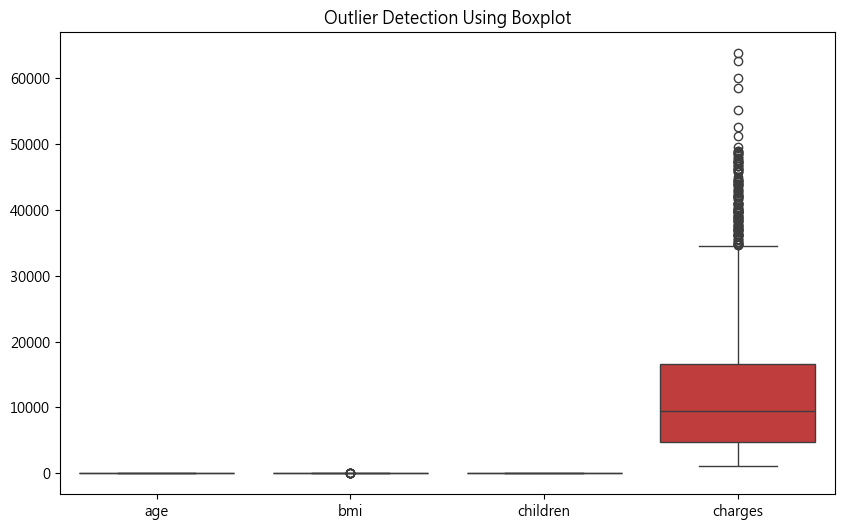

In [4]:
# Outlier Detection Using Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['age', 'bmi', 'children', 'charges']])
plt.title("Outlier Detection Using Boxplot")
plt.show()


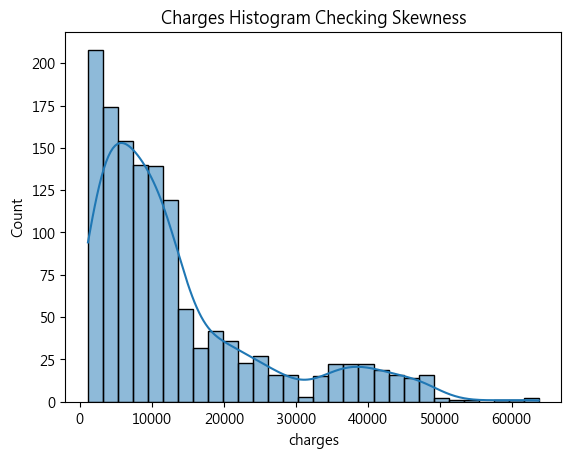

In [5]:
# 使用分佈圖（histogram）檢查 charges 是否呈現偏態
sns.histplot(df['charges'], kde=True)
plt.title("Charges Histogram Checking Skewness")
plt.show()


#### **charges 偏態嚴重，進行 log 轉換**

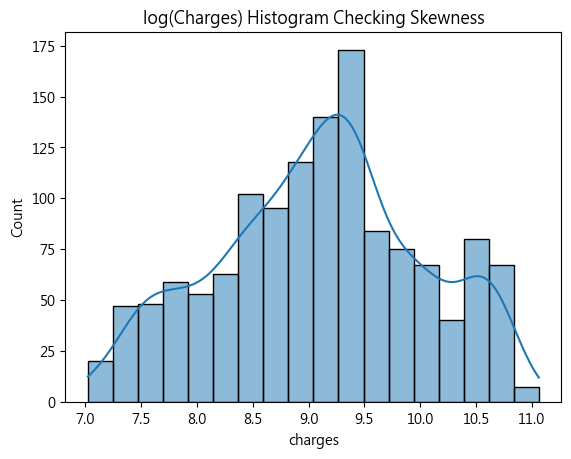

In [6]:
# charges -> log()
df['charges'] = np.log(df['charges'])
sns.histplot(df['charges'], kde=True)
plt.title("log(Charges) Histogram Checking Skewness")
plt.show()


#### **相關性分析**

In [7]:
# Pearson Correlation Coefficient - df.corr()
corr_matrix = df.corr()
print(corr_matrix['charges'].sort_values(ascending=False))


charges             1.000000
smoker_yes          0.665506
age                 0.527834
children            0.161336
bmi                 0.132669
region_southeast    0.015791
sex_male            0.005632
region_northwest   -0.017824
region_southwest   -0.041632
Name: charges, dtype: float64


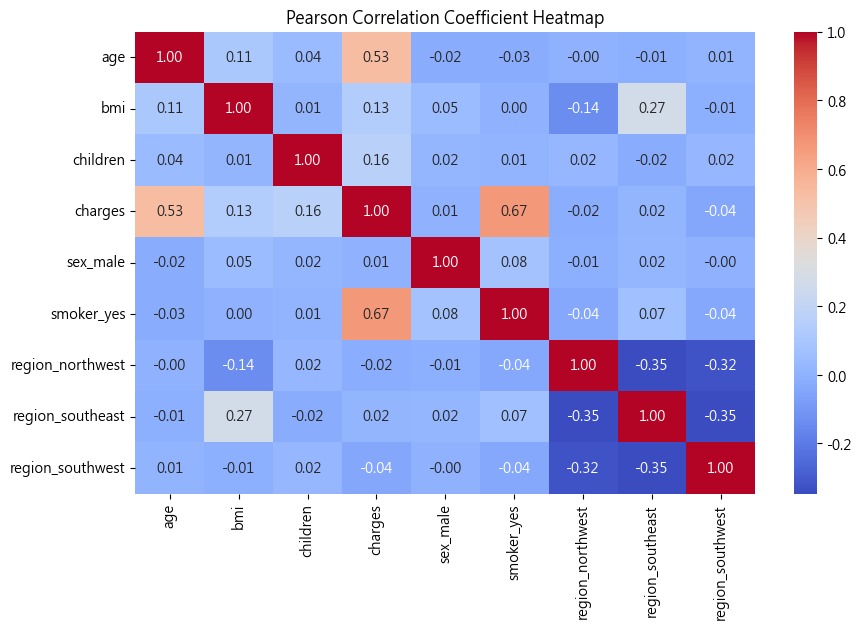

In [9]:
# Pearson Correlation Coefficient Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Pearson Correlation Coefficient Heatmap")
plt.show()


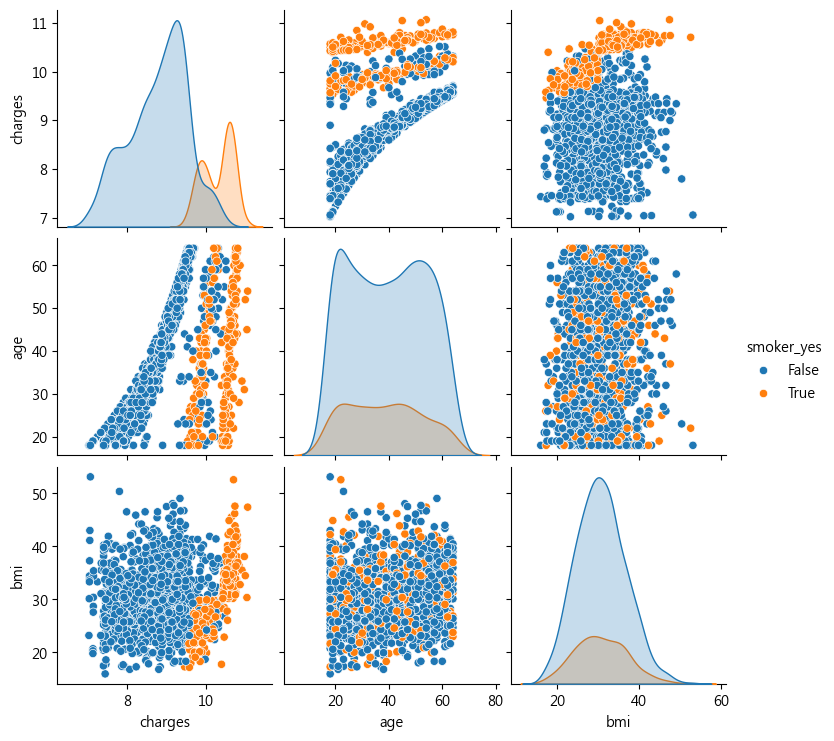

In [11]:
# Scatterplot of Charges vs. Smoker Status, Age, and BMI
sns.pairplot(df, vars=['charges', 'age', 'bmi'], hue='smoker_yes')
plt.show()

#### **小結論**

1. **費用（`charges`）**：
   - 吸煙者的醫療費用顯著高於非吸煙者
   - 非吸煙者的費用分佈右偏，吸煙者的費用分佈呈雙峰，可能表明吸煙者中有一部分人（例如年輕或健康的吸煙者）費用較低，但大多數費用較高。

2. **年齡（`age`）**：
   - 吸煙者和非吸煙者的年齡分佈差異不大，都接近均勻分佈。
   - 年齡不是導致費用差異的主要因素，但單純來看非吸菸者多少有點正相關。

3. **BMI（`bmi`）**：
   - 吸煙者和非吸煙者的 BMI 分佈形狀相似，均值接近 30，皆為常態分布。
   - 吸煙者的 BMI 似乎存在交互項關係，BMI 過 30 以後費用有提高。
   
4. **子女數（children）**：0.180 影響較小，可以考慮是否納入。   
5. **地區（region_*）**：影響極小，可捨棄。
6. **性別（sex_male）**：-0.006 幾乎無影響，可以不納入。

### **Baseline Model 解釋交互項的關係**

In [14]:
# bmi * smoker = interaction terms
df['bmi_smoker_interaction'] = df['bmi'] * df['smoker_yes'] #  Python 在數值運算中會將 True / False 自動轉換為 1 和 0
X = df['bmi_smoker_interaction']
y = df['charges']

'''
sklearn 的 LinearRegression() 必須吃二維以上的 Dataframe or np.array
因此 X 的形狀必須符合要求：(n_samples, 1)

有三種辦法：
方法 1：X = df[['bmi_smoker_interaction']]
方法 2：X = df['bmi_smoker_interaction'].values.reshape(-1, 1)
方法 3：X = df['bmi_smoker_interaction'].to_frame()
三種都只改變數據的形狀，不改變數據的值或順序
'''

X = df['bmi_smoker_interaction'].values.reshape(-1, 1)

# === 基準模型：使用 DummyRegressor 只預測全體平均 ===
dummy_model = DummyRegressor(strategy="mean")
dummy_model.fit(X, y)
y_pred_baseline = dummy_model.predict(X)

# === 分組模型：根據自變數來預測值 ===
linear_model = LinearRegression()
linear_model.fit(X, y)
y_pred_interaction = linear_model.predict(X)

# === RMSE ===
rmse_baseline = np.sqrt(mean_squared_error(y, y_pred_baseline))
rmse_interaction = np.sqrt(mean_squared_error(y, y_pred_interaction))

# === r2 ===
r2_baseline = r2_score(y, y_pred_baseline)
r2_interaction = r2_score(y, y_pred_interaction)

print(f"{'Baseline Model':-<24} log RMSE: {rmse_baseline:.5f} | r2: {r2_baseline:.5f}")
print(f"{'Interaction terms':-<24} log RMSE: {rmse_interaction:.5f} | r2: {r2_interaction:.5f}")


Baseline Model---------- log RMSE: 0.91918 | r2: 0.00000
Interaction terms------- log RMSE: 0.67140 | r2: 0.46646


#### **小結論**

- **log RMSE**：交互項模型的 log RMSE 降低了約 27%（從 0.91918 降到 0.67140），是一個顯著的改進，說明 bmi_smoker_interaction 特徵幫助模型更好地預測 charges。
- **R²**：交互項模型的 R² 從 0 提高到 0.46646，表明它比基準模型多解釋了 46.646% 的變異，也是一個顯著的進步。


### **加入更多特徵**

- 仍有 53.354% 的變異未被解釋，可以加入更多特徵（age、bmi、smoker_yes）
- 加入 smoker_yes 本身可以讓模型直接捕捉吸煙狀態的主效應（main effect），而 bmi_smoker_interaction 則捕捉交互效應。

In [16]:
print(df.columns)

Index(['age', 'bmi', 'children', 'charges', 'sex_male', 'smoker_yes',
       'region_northwest', 'region_southeast', 'region_southwest',
       'bmi_smoker_interaction'],
      dtype='object')


### **Run Linear Model**

- **X = age、bmi、smoker_yes、bmi_smoker_interaction**

- **cross_validate() 包含模型訓練，其會返回一個字典，內容為以下鍵值對：**
    1. fit_time：每個 fold 的訓練時間。
    2. score_time：每個 fold 的驗證時間。
    3. test_(scorer)：每個 fold 的測試集評估結果，
    4. train_(scorer)每個 fold 的訓練集評估結果（如果 return_train_score=True）。
    5. estimator：每個 fold 訓練後的模型物件（如果 return_estimator=True）。
        - scorer 是評估指標的名稱

- **make_scorer()：將一個自訂的評估函數轉換為一個評估器物件。**

In [17]:
X = df[['bmi_smoker_interaction','age','bmi','smoker_yes']]
y = df['charges']

# feature classification
numeric_features = ['bmi_smoker_interaction','age','bmi']
categorical_features = ['smoker_yes']

# feature transform
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

# 整合數值和類別特徵，輸出統一的特徵矩陣
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# metrics
scoring = {
    'r2': 'r2',
    'rmse': make_scorer(rmse) # 將 RMSE 函數轉換為評估器物件
}

# evaluation
cv = KFold(n_splits=5, shuffle=True, random_state=2024)
scores = cross_validate(model, X, y, cv=cv, scoring=scoring)

# 5-folds
print("Cross-validated R^2 scores:", scores['test_r2'])
print(f"Mean R^2: {scores['test_r2'].mean():.5f}")
print(f"Std R^2: {scores['test_r2'].std():.5f}")

print("\nCross-validated RMSE scores:", scores['test_rmse'])
print(f"Mean RMSE: {scores['test_rmse'].mean():.5f}")
print(f"Std RMSE: {scores['test_rmse'].std():.5f}")


Cross-validated R^2 scores: [0.75096551 0.73632748 0.73453343 0.73792656 0.81747907]
Mean R^2: 0.75545
Std R^2: 0.03155

Cross-validated RMSE scores: [0.47291743 0.46720354 0.43643393 0.48375196 0.39965306]
Mean RMSE: 0.45199
Std RMSE: 0.03053


#### **children 加入 X**

In [18]:
X = df[['bmi_smoker_interaction','age','bmi','smoker_yes','children']]
y = df['charges']

# feature classification
numeric_features = ['bmi_smoker_interaction','age','bmi','children']
categorical_features = ['smoker_yes']

# feature transform
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

# 整合數值和類別特徵，輸出統一的特徵矩陣
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# metrics
scoring = {
    'r2': 'r2',
    'rmse': make_scorer(rmse) # 將 RMSE 函數轉換為評估器物件
}

# evaluation
cv = KFold(n_splits=5, shuffle=True, random_state=2024)
scores = cross_validate(model, X, y, cv=cv, scoring=scoring)

# 5-folds
print("Cross-validated R^2 scores:", scores['test_r2'])
print(f"Mean R^2: {scores['test_r2'].mean():.5f}")
print(f"Std R^2: {scores['test_r2'].std():.5f}")

print("\nCross-validated RMSE scores:", scores['test_rmse'])
print(f"Mean RMSE: {scores['test_rmse'].mean():.5f}")
print(f"Std RMSE: {scores['test_rmse'].std():.5f}")



Cross-validated R^2 scores: [0.76696975 0.75897555 0.74658894 0.75638678 0.83781722]
Mean R^2: 0.77335
Std R^2: 0.03289

Cross-validated RMSE scores: [0.45746905 0.44668796 0.426409   0.46640335 0.37672911]
Mean RMSE: 0.43474
Std RMSE: 0.03193


#### **對比納入前結果**

| **指標** | **原始模型** | **加入 `children` 後** | **變化** |
|---------|------------|----------------|----------|
| **Mean $R^2$** | 0.75593 | **0.77369** |**上升 1.78%** |
| **Std $R^2$** | 0.05056 | **0.05144** | 輕微增加（變異性略高） |
| **Mean RMSE** | 0.45121 | **0.43404** | **下降 3.81%** |
| **Std RMSE** | 0.04444 | **0.04774** | 變異性略增 |

- **$R^2$ 提升**：說明 `children` 這個變數 **提升了模型的解釋能力**，能夠解釋更多 `charges` 的變異性。  
- **RMSE 下降**：表示模型的誤差變小，預測變得更加精確。  
- **標準差略升**：變異性稍微增加，可能代表不同 fold 的結果有些不穩定，但影響不大。  

#### **檢查是否需要 L1（Lasso）或 L2（Ridge）**

In [19]:
X = df[['bmi_smoker_interaction', 'age', 'bmi', 'smoker_yes', 'children']]
X = X.astype(float) # 轉換非數值型數據
print(f"X null counts:\n{X.isnull().sum()}")

X = sm.add_constant(X)  # 添加 constant 截距項
model = sm.OLS(y, X).fit()
print(model.summary())
# 查看變數係數和 p-value


X null counts:
bmi_smoker_interaction    0
age                       0
bmi                       0
smoker_yes                0
children                  0
dtype: int64
                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     927.5
Date:                Wed, 02 Apr 2025   Prob (F-statistic):               0.00
Time:                        02:20:52   Log-Likelihood:                -782.32
No. Observations:                1338   AIC:                             1577.
Df Residuals:                    1332   BIC:                             1608.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std e

### **Result**

**整體模型適配度**
| 指標 | 數值 | 解讀 |
|------|------|------|
| **$R^2$** | 0.777 | **模型可解釋 77.7% 的 `charges` 變異性**|
| **Adj. $R^2$** | 0.776 | 考慮自由度後，仍維持良好適配度。|
| **F-statistic** | 927.5 | **F 檢定顯著**，表示至少有一個變數對 `charges` 具有影響力。|
| **Prob(F-statistic)** | 0.000 | **P-value < 0.05，拒絕虛無假設**，表示整體模型有顯著解釋力。|
| **AIC / BIC** | 1577 / 1608 | 這些指標可用於模型比較，數值越小代表模型越好。|


**變數影響力分析**
| 變數 | 係數 (coef) | P-value | 解釋 |
|------|------------|--------|------|
| **const** | 7.2718 | 0.000 | **截距項**，表示當所有變數為 0 時，`charges` 的預測值。 |
| **bmi_smoker_interaction** | **0.0442** | **0.000** ✔ | **顯著影響**，BMI 與吸菸的交互作用**對 `charges` 有強烈影響**，每增加 1 單位，`charges` 會增加 **0.0442** 單位。 |
| **age** | **0.0350** | **0.000** ✔ | **年齡顯著影響 `charges`**，年齡每增加 1 歲，`charges` 增加**0.0350** 單位。 |
| **bmi** | 0.0009 | 0.699 ✘ | **不顯著**（P = 0.699 > 0.05），表示 BMI 本身對 `charges` 的影響**可能不大**，這可能是因為 `bmi_smoker_interaction` 已經捕捉了 BMI 的影響。 |
| **smoker_yes** | 0.1862 | 0.208 ✘ | **不顯著**（P = 0.208 > 0.05），表示當單獨考慮吸菸時，它的影響可能不大，因為 `bmi_smoker_interaction` 變數已經強烈影響 `charges`。 |
| **children** | **0.1023** | **0.000** ✔ | **顯著影響**，每增加一個子女，`charges` 平均增加**0.1023** 單位。|

**可能的原因**：`bmi_smoker_interaction` 已經強烈捕捉 BMI 和吸菸的影響，導致 `bmi` 和 `smoker_yes` 變得不重要。